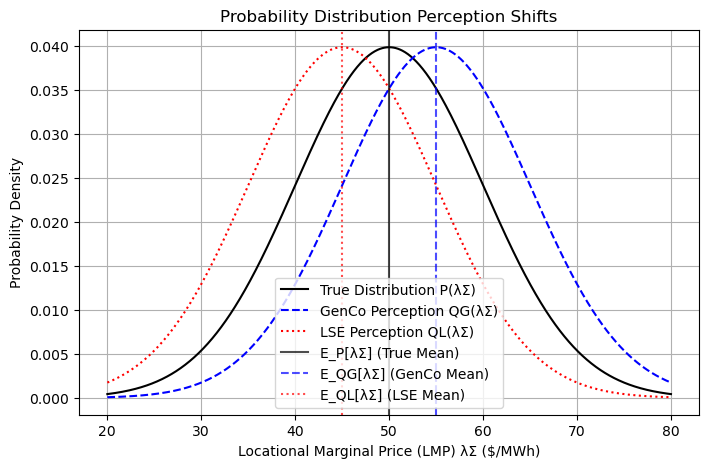

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Define the true probability distribution (Normal Distribution for LMP)
mu_true = 50  # True mean
sigma = 10    # Standard deviation

# Define biased distributions
K_G = 5   # Shift for GenCo
K_L = -5  # Shift for LSE

# Generate x values
x = np.linspace(20, 80, 1000)

# Compute probability densities
pdf_true = stats.norm.pdf(x, mu_true, sigma)       # True distribution
pdf_genco = stats.norm.pdf(x, mu_true + K_G, sigma)  # Shifted for GenCo
pdf_lse = stats.norm.pdf(x, mu_true + K_L, sigma)   # Shifted for LSE

# Plot the distributions
plt.figure(figsize=(8, 5))
plt.plot(x, pdf_true, label="True Distribution P(λΣ)", color='black')
plt.plot(x, pdf_genco, label="GenCo Perception QG(λΣ)", color='blue', linestyle='dashed')
plt.plot(x, pdf_lse, label="LSE Perception QL(λΣ)", color='red', linestyle='dotted')

# Add vertical lines to show mean shifts
plt.axvline(mu_true, color='black', linestyle='solid', alpha=0.7, label="E_P[λΣ] (True Mean)")
plt.axvline(mu_true + K_G, color='blue', linestyle='dashed', alpha=0.7, label="E_QG[λΣ] (GenCo Mean)")
plt.axvline(mu_true + K_L, color='red', linestyle='dotted', alpha=0.7, label="E_QL[λΣ] (LSE Mean)")

# Labels and legend
plt.xlabel("Locational Marginal Price (LMP) λΣ ($/MWh)")
plt.ylabel("Probability Density")
plt.title("Probability Distribution Perception Shifts")
plt.legend()
plt.grid()


In [12]:

import numpy as np
import matplotlib.pyplot as plt
test =   np.insert(np.round(np.linspace(0.1, 0.9, 3), 3), 0, 0)
test


array([0. , 0.1, 0.5, 0.9])

(array([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.]),
 array([197620.37913645, 197620.47913645, 197620.57913645, 197620.67913645,
        197620.77913645, 197620.87913645, 197620.97913645, 197621.07913645,
        197621.17913645, 197621.27913645, 197621.37913645]),
 <BarContainer object of 10 artists>)

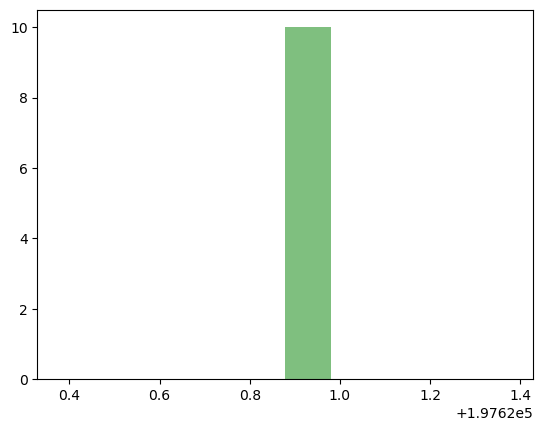

In [14]:
test = np.array([197620.87913645, 197620.87913645, 197620.87913645, 197620.87913645,
       197620.87913645, 197620.87913645, 197620.87913645, 197620.87913645,
       197620.87913645, 197620.87913645])
plt.hist(test, bins=10, density=True, alpha=0.5, color='g', label='Test Data')

C:\Users\ande7\AppData\Local\Temp\ipykernel_32812\1463981638.py:32: UserWarning: Glyph 120021 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL F}) missing from current font.
  plt.tight_layout()
c:\Users\ande7\anaconda3\envs\optimization\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 120021 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


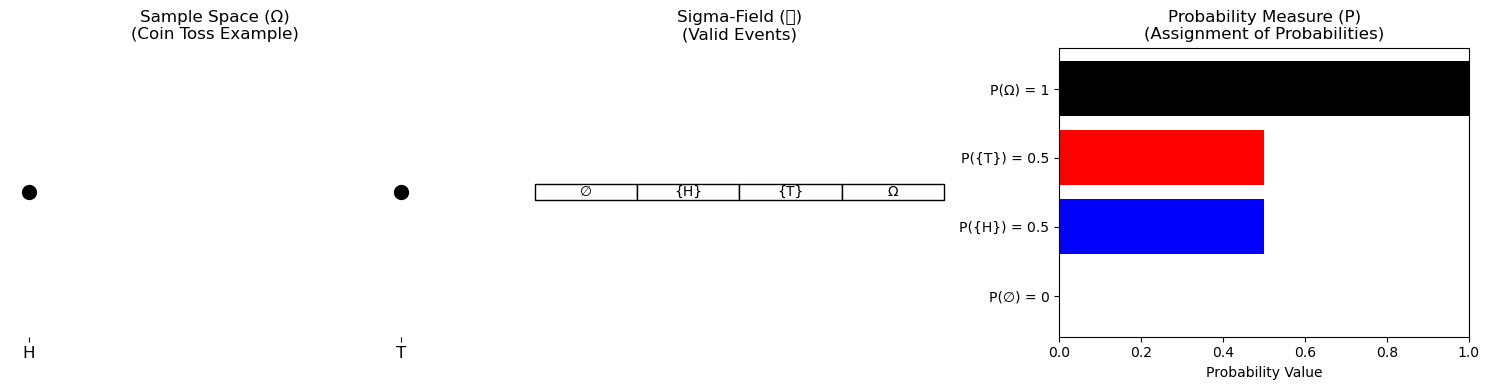

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Sample Space Visualization
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Sample Space (Ω)
omega = ['H', 'T']
ax[0].scatter(omega, [1, 1], color='black', s=100)
ax[0].set_xticks(range(len(omega)))
ax[0].set_xticklabels(omega, fontsize=12)
ax[0].set_yticks([])
ax[0].set_title("Sample Space (Ω)\n(Coin Toss Example)")
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

# Sigma-Field (F)
sigma_field = [["∅", "{H}", "{T}", "Ω"]]
ax[1].table(cellText=sigma_field, loc="center", cellLoc='center')
ax[1].axis("off")
ax[1].set_title("Sigma-Field (𝓕)\n(Valid Events)")

# Probability Measure (P)
event_labels = ["P(∅) = 0", "P({H}) = 0.5", "P({T}) = 0.5", "P(Ω) = 1"]
ax[2].barh(event_labels, [0, 0.5, 0.5, 1], color=['gray', 'blue', 'red', 'black'])
ax[2].set_xlim(0, 1)
ax[2].set_xlabel("Probability Value")
ax[2].set_title("Probability Measure (P)\n(Assignment of Probabilities)")

plt.tight_layout()
plt.show()

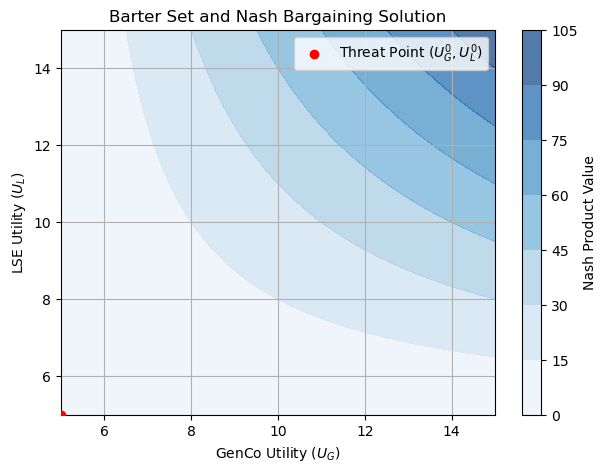

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the threat point (worst-case scenario utilities)
U_G0, U_L0 = 5, 5  # Arbitrary threat point values

# Generate a barter set (random feasible utility pairs above the threat point)
U_G = np.linspace(U_G0, 15, 100)
U_L = np.linspace(U_L0, 15, 100)
U_G_grid, U_L_grid = np.meshgrid(U_G, U_L)

# Define Nash Product (objective function to be maximized in bargaining)
Nash_Product = (U_G_grid - U_G0) * (U_L_grid - U_L0)

# Plot the barter set region
plt.figure(figsize=(7, 5))
plt.contourf(U_G_grid, U_L_grid, Nash_Product, cmap="Blues", alpha=0.7)  # Feasible region
plt.colorbar(label="Nash Product Value")

# Mark threat point
plt.scatter(U_G0, U_L0, color='red', label="Threat Point $(U_G^0, U_L^0)$", zorder=3)

# Annotate key elements
plt.xlabel("GenCo Utility $(U_G)$")
plt.ylabel("LSE Utility $(U_L)$")
plt.title("Barter Set and Nash Bargaining Solution")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [17]:
import numpy as np
import scipy.optimize as opt

# Define threat points (fallback utilities if no contract is signed)
U_G0 = 5  # Threat point for GenCo
U_L0 = 5  # Threat point for LSE

# Define expected earnings functions (simplified model)
def expected_earnings_genco(Q, S):
    return Q * (S - 30)  # Example: selling electricity at strike price minus cost

def expected_earnings_lse(Q, S):
    return Q * (50 - S)  # Example: buying electricity at strike price lower than retail price

# Define risk-adjusted utility functions using CVaR approximation
def cvar(losses, alpha=0.95):
    """Compute Conditional Value-at-Risk (CVaR)"""
    var = np.percentile(losses, (1 - alpha) * 100)
    return losses[losses >= var].mean()

def cvar_genco(Q, S):
    losses = np.random.normal(5, 2, 1000) * Q  # Example loss distribution
    return cvar(losses)

def cvar_lse(Q, S):
    losses = np.random.normal(4, 1.5, 1000) * Q  # Example loss distribution
    return cvar(losses)

# Define risk aversion parameters
gamma_G = 1.0  # Risk aversion for GenCo
gamma_L = 1.5  # Risk aversion for LSE

# Define Nash bargaining objective function
def nash_product(x):
    Q, S = x  # Contract quantity and strike price
    U_G = expected_earnings_genco(Q, S) - gamma_G * cvar_genco(Q, S)
    U_L = expected_earnings_lse(Q, S) - gamma_L * cvar_lse(Q, S)
    return -(U_G - U_G0) * (U_L - U_L0)  # Maximizing Nash product (negative for minimization)

# Define contract constraints
Q_bounds = (100, 500)  # Contract quantity bounds (MW)
S_bounds = (25, 45)   # Strike price bounds ($/MWh)

# Optimize Nash product
result = opt.minimize(nash_product, x0=[(Q_bounds[0] + Q_bounds[1]) / 2, (S_bounds[0] + S_bounds[1]) / 2], bounds=[Q_bounds, S_bounds])

# Extract optimal values
Q_opt, S_opt = result.x if result.success else (None, None)

# Display results
Q_opt, S_opt


(300.00000001509693, 34.9999999985919)

In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Define threat points (fallback utilities if no contract is signed)
U_G0 = 5  # Threat point for GenCo
U_L0 = 5  # Threat point for LSE

# Define expected earnings functions (simplified model)
def expected_earnings_genco(Q, S):
    return Q * (S - 30)  # Example: selling electricity at strike price minus cost

def expected_earnings_lse(Q, S):
    return Q * (50 - S)  # Example: buying electricity at strike price lower than retail price

# Define risk-adjusted utility functions using CVaR approximation
def cvar(losses, alpha=0.95):
    """Compute Conditional Value-at-Risk (CVaR)"""
    var = np.percentile(losses, (1 - alpha) * 100)
    return losses[losses >= var].mean()

def cvar_genco(Q, S):
    losses = np.random.normal(5, 2, 1000) * Q  # Example loss distribution
    return cvar(losses)

def cvar_lse(Q, S):
    losses = np.random.normal(4, 1.5, 1000) * Q  # Example loss distribution
    return cvar(losses)

# Define risk aversion parameters
gamma_G = 1.0  # Risk aversion for GenCo
gamma_L = 1.5  # Risk aversion for LSE

# Define contract constraints
Q_bounds = (100, 500)  # Contract quantity bounds (MW)
S_bounds = (25, 45)   # Strike price bounds ($/MWh)

# Gurobi model for Nash bargaining
def nash_bargaining_gurobi():
    model = gp.Model("Nash_Bargaining")
    
    # Decision variables
    Q = model.addVar(lb=Q_bounds[0], ub=Q_bounds[1], name="Q")
    S = model.addVar(lb=S_bounds[0], ub=S_bounds[1], name="S")
    
    # Utility functions
    U_G = expected_earnings_genco(Q, S) - gamma_G * cvar_genco(Q, S)
    U_L = expected_earnings_lse(Q, S) - gamma_L * cvar_lse(Q, S)
    
    # Nash product objective
    nash_product = (U_G - U_G0) * (U_L - U_L0)
    model.setObjective(-nash_product, GRB.MINIMIZE)  # Minimize the negative Nash product
    
    # Optimize the model
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return Q.X, S.X
    else:
        return None, None

# Solve the Nash bargaining problem using Gurobi
Q_opt, S_opt = nash_bargaining_gurobi()

# Display results
print(f"Optimal contract quantity (Q_opt): {Q_opt} MW")
print(f"Optimal strike price (S_opt): ${S_opt}/MWh")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-24


NotImplementedError: 

In [21]:
import numpy as np
import scipy.optimize as opt

# Given risk aversion parameters for GenCo and LSE
A_G = 1.2  # Risk aversion coefficient for GenCo
A_L = 1.0  # Risk aversion coefficient for LSE

# Expected market price and CVaR values (assumed for demonstration)
E_P_lambda = 50  # Expected price under true distribution
CVaR_P_lambda = 10  # Conditional Value at Risk for positive deviations
CVaR_P_neg_lambda = 8  # Conditional Value at Risk for negative deviations

# Bias shift factors
K_G = 3  # Bias in GenCo's perception
K_L = -2  # Bias in LSE's perception

# Transaction surplus (TS)
TS = 1

# Define contract amount bounds (assumed range)
M_min, M_max = 100, 500

# Define functions for Nash product optimization
def nash_product(x):
    Q, S = x  # Contract quantity and strike price
    
    # Compute risk-adjusted utilities
    U_G = E_P_lambda * Q - A_G * CVaR_P_lambda * Q - K_G * Q
    U_L = (50 - S) * Q - A_L * CVaR_P_neg_lambda * Q - K_L * Q

    # Ensure utilities are above threat points
    U_G0, U_L0 = 5, 5  # Fallback utilities
    return -(U_G - U_G0) * (U_L - U_L0)  # Maximizing Nash product (negative for minimization)

# Contract quantity and price bounds
Q_bounds = (M_min, M_max)  # Contract quantity bounds (MW)
S_bounds = (25, 45)  # Strike price bounds ($/MWh)

# Solve Nash Bargaining problem
result = opt.minimize(nash_product, x0=[(Q_bounds[0] + Q_bounds[1]) / 2, (S_bounds[0] + S_bounds[1]) / 2], bounds=[Q_bounds, S_bounds])

# Optimal contract terms
Q_opt, S_opt = result.x if result.success else (None, None)

# Compute the upper and lower contract limits from equations (29) and (30)
M_U = (A_G - A_L) / (A_L * (1 + A_G)) * E_P_lambda - (A_G * (1 + A_L)) / (A_L * (1 + A_G)) * CVaR_P_lambda + (1 / A_L) * K_L - (1 + A_L) / A_L * K_G + TS
M_R = (A_G - A_L) / (A_L * (1 + A_G)) * E_P_lambda + (A_G * (1 + A_L)) / (A_L * (1 + A_G)) * CVaR_P_neg_lambda + (1 / A_L) * K_L - (1 + A_L) / A_L * K_G + TS

# Compute the strike price bounds from equations (27) and (28)
S_R_star = min(
    (E_P_lambda + A_G * CVaR_P_lambda + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda - A_G * CVaR_P_neg_lambda + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda + (1 + A_L) * K_L - A_L * CVaR_P_lambda) / (1 + A_L)
)

S_U_star = max(
    (E_P_lambda + A_G * CVaR_P_lambda + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda - A_G * CVaR_P_neg_lambda + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda + (1 + A_L) * K_L + A_L * CVaR_P_lambda) / (1 + A_L)
)

# Display results
Q_opt, S_opt, M_U, M_R, S_R_star, S_U_star


(500.0, 25.0, -13.363636363636363, 6.27272727272727, 18.0, 31.181818181818176)

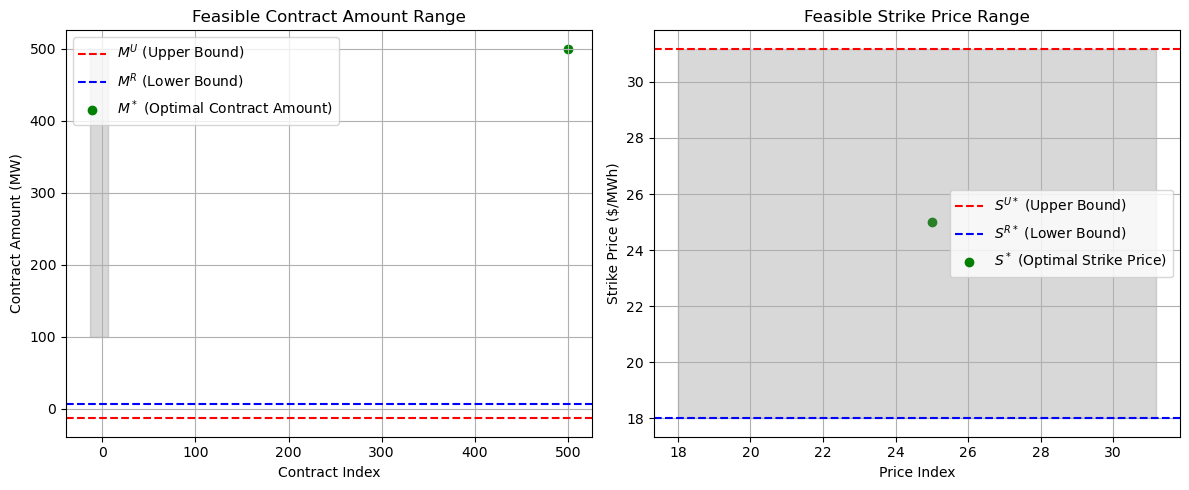

In [22]:
import matplotlib.pyplot as plt

# Data for visualization
contract_sizes = np.linspace(M_min, M_max, 100)
strike_prices = np.linspace(S_R_star, S_U_star, 100)

# Create a figure with two subplots: one for contract amount, one for strike price
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Contract amount visualization
ax[0].axhline(M_U, color='red', linestyle='--', label=r'$M^U$ (Upper Bound)')
ax[0].axhline(M_R, color='blue', linestyle='--', label=r'$M^R$ (Lower Bound)')
ax[0].scatter(Q_opt, Q_opt, color='green', label=r'$M^*$ (Optimal Contract Amount)')
ax[0].fill_betweenx(contract_sizes, M_R, M_U, color='gray', alpha=0.3)  # Feasible region
ax[0].set_xlabel("Contract Index")
ax[0].set_ylabel("Contract Amount (MW)")
ax[0].set_title("Feasible Contract Amount Range")
ax[0].legend()
ax[0].grid()

# Strike price visualization
ax[1].axhline(S_U_star, color='red', linestyle='--', label=r'$S^{U*}$ (Upper Bound)')
ax[1].axhline(S_R_star, color='blue', linestyle='--', label=r'$S^{R*}$ (Lower Bound)')
ax[1].scatter(S_opt, S_opt, color='green', label=r'$S^*$ (Optimal Strike Price)')
ax[1].fill_betweenx(strike_prices, S_R_star, S_U_star, color='gray', alpha=0.3)  # Feasible region
ax[1].set_xlabel("Price Index")
ax[1].set_ylabel("Strike Price ($/MWh)")
ax[1].set_title("Feasible Strike Price Range")
ax[1].legend()
ax[1].grid()

# Show the plot
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

# Parameters (example values)
A_G = 1.0  # GenCo's risk-aversion factor
A_L = 1.0  # LSE's risk-aversion factor
zeta_1 = 100  # Threat point utility for GenCo
zeta_2 = 150  # Threat point utility for LSE
mu_lambda = 500  # Mean of lambda (sum of LMPs over contract period)
sigma_lambda = 50  # Standard deviation of lambda
T = 24  # Number of time slots (e.g., hours)
alpha = 0.95  # Confidence level for CVaR
M_lower = 0  # Lower bound for contract amount
M_upper = 600  # Upper bound for contract amount
S_lower = 15  # Lower bound for strike price
S_upper = 25  # Upper bound for strike price
num_scenarios = 1000  # Number of load scenarios
C = 10  # Production cost for GenCo ($/MWh)
retail = 30  # Retail price for LSE ($/MWh)

# Generate 1000 scenarios for lambda and load, with T time slots
np.random.seed(42)  # For reproducibility
lambda_scenarios = np.random.normal(mu_lambda, sigma_lambda, (num_scenarios, T))
load_scenarios = np.random.normal(300, 50, (num_scenarios, T))  # Example load scenarios

# Optimal production P_g[s, t] for GenCo (example: proportional to lambda)
P_g_scenarios = lambda_scenarios / mu_lambda * 300  # Example: scaled to 300 MW

# CVaR calculation for a set of scenarios
def calculate_cvar_scenarios(losses, alpha):
    """Calculate CVaR for a set of scenarios."""
    sorted_losses = np.sort(losses)
    n = len(sorted_losses)
    index = int(np.ceil(alpha * n)) - 1  # Index for the (1 - alpha) quantile
    return np.mean(sorted_losses[index:])  # Average of the worst (1 - alpha) losses

# Objective function
def objective_function(x):
    """Objective function to maximize (u_G - zeta_1) * (u_L - zeta_2)."""
    M, S = x  # Unpack decision variables

    # Initialize arrays to store utilities for each scenario
    u_G_scenarios = np.zeros(num_scenarios)
    u_L_scenarios = np.zeros(num_scenarios)

    # Loop through each scenario
    for i in range(num_scenarios):
        # Initialize earnings for this scenario
        pi_G_s = 0  # GenCo's total earnings in scenario s
        pi_L_s = 0  # LSE's total earnings in scenario s

        # Loop through each time slot
        for t in range(T):
            lambda_s_t = lambda_scenarios[i, t]
            load_s_t = load_scenarios[i, t]
            P_g_s_t = P_g_scenarios[i, t]

            # GenCo's earnings in this time slot
            pi_G_s += P_g_s_t * (lambda_s_t - C) + (S - lambda_s_t) * M

            # LSE's earnings in this time slot
            pi_L_s += load_s_t * (retail - S) + (lambda_s_t - S) * M

        # Loss functions for CVaR calculation
        loss_G = -pi_G_s  # Negative of net earnings for GenCo
        loss_L = -pi_L_s  # Negative of net earnings for LSE

        # Store utilities for this scenario
        u_G_scenarios[i] = pi_G_s - A_G * loss_G
        u_L_scenarios[i] = pi_L_s - A_L * loss_L

    # Calculate CVaR across all scenarios
    CVaR_G = calculate_cvar_scenarios(-u_G_scenarios, alpha)
    CVaR_L = calculate_cvar_scenarios(-u_L_scenarios, alpha)

    # Average utilities across all scenarios
    u_G = np.mean(u_G_scenarios)
    u_L = np.mean(u_L_scenarios)

    # Objective: maximize (u_G - zeta_1) * (u_L - zeta_2)
    return -(u_G - zeta_1) * (u_L - zeta_2)  # Negative for minimization

# Bounds for M and S
bounds = [(M_lower, M_upper), (S_lower, S_upper)]

# Initial guess for M and S
initial_guess = [300, 20]  # Example initial guess

# Constraints (if any)
# For example, you could add constraints on M and S here if needed
constraints = []  # No additional constraints in this example

# Optimize using scipy.optimize.minimize
result = minimize(
    objective_function,
    initial_guess,
    bounds=bounds,
    constraints=constraints,
    method='SLSQP'  # Sequential Least Squares Programming
)

# Output the results
if result.success:
    optimal_M, optimal_S = result.x
    max_objective_value = -result.fun  # Negate to get the original objective value
    print(f"Optimal Contract Amount (M): {optimal_M}")
    print(f"Optimal Strike Price (S): {optimal_S}")
    print(f"Maximum Objective Value: {max_objective_value}")
else:
    print("Optimization failed:", result.message)

Optimization failed: Inequality constraints incompatible


In [8]:
import numpy as np
print(sum(np.array([1,2,3,4,5,6,7,8,9,10])*2))
print(sum(np.array([1,2,3,4,5,6,7,8,9,10]))*2)

110
110


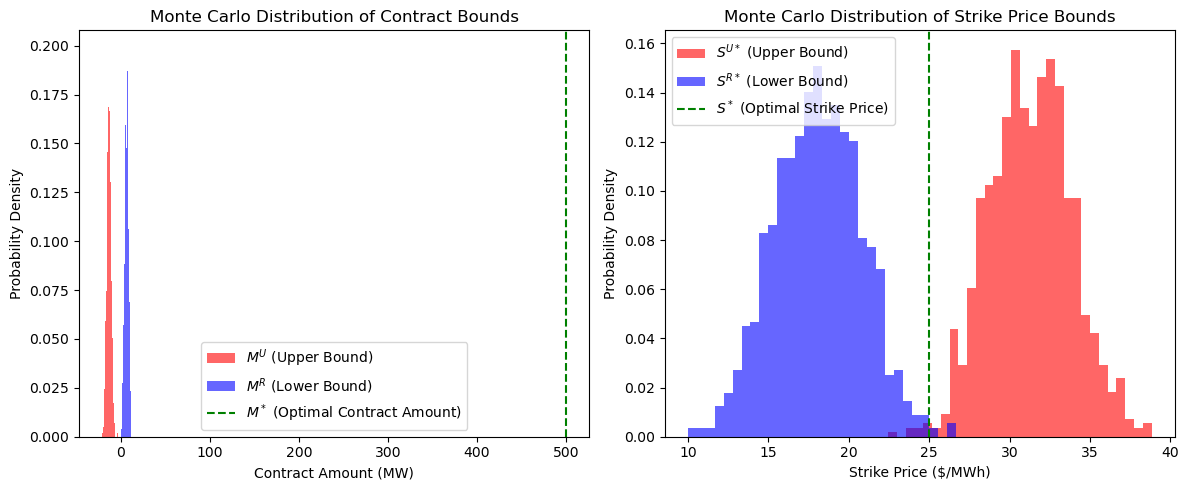

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Monte Carlo Simulation Parameters
num_simulations = 1000

# Generate random expected prices and CVaR values (assuming a normal distribution)
E_P_lambda_samples = np.random.normal(loc=E_P_lambda, scale=5, size=num_simulations)
CVaR_P_lambda_samples = np.random.normal(loc=CVaR_P_lambda, scale=2, size=num_simulations)
CVaR_P_neg_lambda_samples = np.random.normal(loc=CVaR_P_neg_lambda, scale=2, size=num_simulations)

# Compute Monte Carlo estimates for M_U, M_R, S_R_star, and S_U_star
M_U_samples = (A_G - A_L) / (A_L * (1 + A_G)) * E_P_lambda_samples - (A_G * (1 + A_L)) / (A_L * (1 + A_G)) * CVaR_P_lambda_samples + (1 / A_L) * K_L - (1 + A_L) / A_L * K_G + TS
M_R_samples = (A_G - A_L) / (A_L * (1 + A_G)) * E_P_lambda_samples + (A_G * (1 + A_L)) / (A_L * (1 + A_G)) * CVaR_P_neg_lambda_samples + (1 / A_L) * K_L - (1 + A_L) / A_L * K_G + TS

S_R_star_samples = np.minimum.reduce([
    (E_P_lambda_samples + A_G * CVaR_P_lambda_samples + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda_samples - A_G * CVaR_P_neg_lambda_samples + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda_samples + (1 + A_L) * K_L - A_L * CVaR_P_lambda_samples) / (1 + A_L)
])

S_U_star_samples = np.maximum.reduce([
    (E_P_lambda_samples + A_G * CVaR_P_lambda_samples + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda_samples - A_G * CVaR_P_neg_lambda_samples + (1 + A_G) * K_G) / (1 + A_G),
    (E_P_lambda_samples + (1 + A_L) * K_L + A_L * CVaR_P_lambda_samples) / (1 + A_L)
])

# Plot Monte Carlo results for contract amount bounds
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(M_U_samples, bins=30, alpha=0.6, label=r'$M^U$ (Upper Bound)', color='red', density=True)
plt.hist(M_R_samples, bins=30, alpha=0.6, label=r'$M^R$ (Lower Bound)', color='blue', density=True)
plt.axvline(Q_opt, color='green', linestyle='--', label=r'$M^*$ (Optimal Contract Amount)')
plt.xlabel("Contract Amount (MW)")
plt.ylabel("Probability Density")
plt.title("Monte Carlo Distribution of Contract Bounds")
plt.legend()

# Plot Monte Carlo results for strike price bounds
plt.subplot(1, 2, 2)
plt.hist(S_U_star_samples, bins=30, alpha=0.6, label=r'$S^{U*}$ (Upper Bound)', color='red', density=True)
plt.hist(S_R_star_samples, bins=30, alpha=0.6, label=r'$S^{R*}$ (Lower Bound)', color='blue', density=True)
plt.axvline(S_opt, color='green', linestyle='--', label=r'$S^*$ (Optimal Strike Price)')
plt.xlabel("Strike Price ($/MWh)")
plt.ylabel("Probability Density")
plt.title("Monte Carlo Distribution of Strike Price Bounds")
plt.legend()

plt.tight_layout()
plt.show()


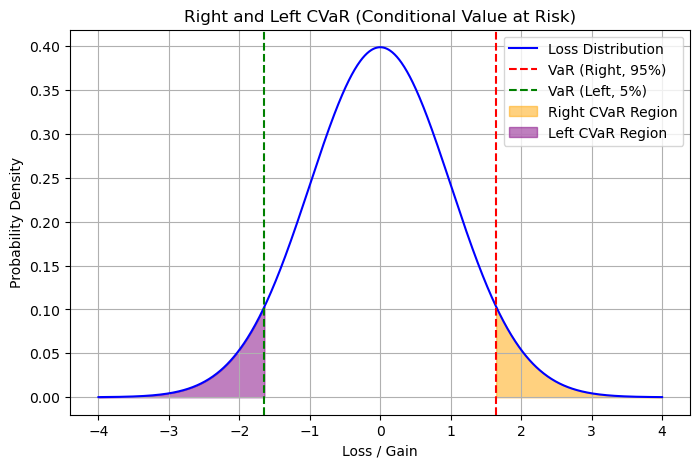

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Generate a normal distribution (representing gains/losses)
mu, sigma = 0, 1  # Mean and standard deviation
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
pdf = stats.norm.pdf(x, mu, sigma)

# Define confidence level for right and left tail
confidence_level = 0.95
VaR_right = stats.norm.ppf(confidence_level, mu, sigma)  # Right-tail VaR
VaR_left = stats.norm.ppf(1 - confidence_level, mu, sigma)  # Left-tail VaR

# Define CVaR regions
x_CVaR_right = np.linspace(VaR_right, mu + 4*sigma, 500)
pdf_CVaR_right = stats.norm.pdf(x_CVaR_right, mu, sigma)

x_CVaR_left = np.linspace(mu - 4*sigma, VaR_left, 500)
pdf_CVaR_left = stats.norm.pdf(x_CVaR_left, mu, sigma)

# Plot the loss distribution
plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label='Loss Distribution', color='blue')
plt.axvline(VaR_right, color='red', linestyle='--', label=f'VaR (Right, {confidence_level*100:.0f}%)')
plt.axvline(VaR_left, color='green', linestyle='--', label=f'VaR (Left, {100 - confidence_level*100:.0f}%)')
plt.fill_between(x_CVaR_right, pdf_CVaR_right, alpha=0.5, color='orange', label='Right CVaR Region')
plt.fill_between(x_CVaR_left, pdf_CVaR_left, alpha=0.5, color='purple', label='Left CVaR Region')

# Labels and legend
plt.xlabel("Loss / Gain")
plt.ylabel("Probability Density")
plt.title("Right and Left CVaR (Conditional Value at Risk)")
plt.legend()
plt.grid()

# Show the plot
plt.show()